# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [79]:
# muda para a pasta original dos arquivos
os.chdir('UCI HAR Dataset')

# carrega a base features, usa um espaço como delimitador
features = pd.read_csv('features.txt', delimiter=' ', header=None)
columns_names = features.transpose().iloc[1].to_list()

# carrega a base de activity_labels
activity_labels = pd.read_csv('activity_labels.txt', delimiter=' ', header=None)

# carrega a base subject_*
subject_train = pd.read_csv('./train/subject_train.txt', header=None)
subject_test = pd.read_csv('./test/subject_test.txt', header=None)

# carrega a base X_* usando 'fixed-width formatted'
X_train = pd.read_fwf('./train/X_train.txt', colspecs='infer', header=None)
# mudar o nome das colunas X_*
X_train.columns = columns_names
# concatena X_* e subject_*
X_train = pd.concat([X_train, subject_train], axis=1)
# renomeando a coluna adicionada
X_train = X_train.rename(columns={0: 'subject_train'})
# definindo a columa subject_* como index
X_train = X_train.set_index(['subject_train'])
# salva a base X_*
X_train.to_csv('./train/X_train.csv', index=True)
# carrega a y_
y_train = pd.read_csv('./train/y_train.txt', delimiter=' ', header=None)


# carrega a base X_* usando 'fixed-width formatted'
X_test = pd.read_fwf('./test/X_test.txt', colspecs='infer', header=None)
# mudar o nome das colunas X_*
X_test.columns = columns_names
# concatena X_* e subject_*
X_test = pd.concat([X_test, subject_test], axis=1)
# renomeando a coluna adicionada
X_test = X_test.rename(columns={0: 'subject_test'})
# definindo a columa subject_* como index
X_test = X_test.set_index(['subject_test'])
# salva a base X_*
X_test.to_csv('./test/X_test.csv', index=True)
# carrega a base y_*
y_test = pd.read_csv('./test/y_test.txt', delimiter=' ', header=None)

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

Cria uma função que calcula a variancia utilizano das componentes principais. A flag 'padroniza' é acionada com True (default), ou desativada com False.

In [80]:
def pca_calculation(n_components: int, X_train=X_train, 
                    X_test = X_test, y_train=y_train, 
                    y_test=y_test, ccp_alpha = 0.001) -> None:



    # Calcula o tempo que o código levou para rodar
    start_time = time.time()

    # Cria modelo PCA
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(X_train)

    # Separa os dados
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                        test_size=0.25, random_state=42) 

    # transforma os dados
    pca_X_train = pca.transform(X_train)
    pca_X_valid = pca.transform(X_valid)
    pca_X_test = pca.transform(X_test)

    # Define a arvore
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(pca_X_train, y_train)

    # Calcula a acurácia
    y_pred_valid = clf.predict(pca_X_valid)
    accuracia_valid = accuracy_score(y_valid, y_pred_valid)

    y_pred_test = clf.predict(pca_X_test)
    accuracia_test = accuracy_score(y_test, y_pred_test)

    # Tempo final do código (sem print)
    end_time = time.time()
    # Tempo total de execução
    tempo_total = end_time - start_time

    # Mostra o resultado
    print(f'\nAcurácia de Validação:{accuracia_valid :.3f}')
    print(f'Acurária de Teste: {accuracia_test :.3f}')

    # Porcentagem de explicação das componentes
    explica = pca.explained_variance_ratio_.cumsum()
    print(f'{n_components} explicam {explica[-1] :.3f} dos dados.\n')

    # Mostra o tempo passado em segundos
    print(f'Tempo: {tempo_total :.2f}s')

    
    return None

In [81]:
def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

def calculo_variancia(n_components:int, pct_explained: float, usa_padroniza=True, X_train=X_train) -> None:


    # normaliza os dados, se requerido
    if usa_padroniza:
        print('Base padronizada')
        X_train = pd.DataFrame(X_train).apply(padroniza, axis=0)
    else:
        print('Base não padronizada.')

   # PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_train)

    # variancia explicada para cada componente
    var_exp = pca.explained_variance_ratio_
    
    # variancia explicada cumulativa 
    cum_var_exp = np.cumsum(var_exp)
    
    # variancia explicada percentual
    var_pct = var_exp * 100
    
    # variancia explicada cumulativa percentual
    cum_var_pct = np.cumsum(var_pct)
    
    # Plot
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0, 0].plot(range(1, len(var_exp)+1), var_exp, marker='o')
    axs[0, 0].set_xlabel('Componentes')
    axs[0, 0].set_ylabel('Variância Explicada')
    axs[0, 0].set_title('Scree Plot')
    
    axs[0, 1].plot(range(1, len(cum_var_exp)+1), cum_var_exp, marker='o')
    axs[0, 1].set_xlabel('Componentes')
    axs[0, 1].set_ylabel('Variância Explicada Acumulativa')
    axs[0, 1].set_title('Variância Explicada Acumulativa')
    
    axs[1, 0].plot(range(1, len(var_pct)+1), var_pct, marker='o')
    axs[1, 0].set_xlabel('Componentes')
    axs[1, 0].set_ylabel('Variância Explicada (%)')
    axs[1, 0].set_title('Variância Explicada (%)')
    
    axs[1, 1].plot(range(1, len(cum_var_pct)+1), cum_var_pct, marker='o')
    axs[1, 1].set_xlabel('Componentes')
    axs[1, 1].set_ylabel('Variância Explicada Acumulativa (%)')
    axs[1, 1].set_title('Variância Explicada Acumulativa (%)')
    

    # Find the index where the cumulative variance first exceeds 90%
    idx90 = np.argmax(cum_var_pct >= pct_explained)

    # Draw a horizontal line at 90%
    axs[1, 1].axhline(y=90, color='red', linestyle='--')

    # Draw a vertical line at the point where it intersects the cumulative variance plot
    axs[1, 1].axvline(x=idx90+1, color='red', linestyle='--')

    # mostra qual o numero de componentes para x%
    print(f'Componentes que explicam {pct_explained}% dos dados: {idx90} componentes')


    plt.tight_layout()
    plt.show()
    
    return None

In [82]:
# define a função principal
"""

A primeira parte, mostra a métrica PCA e uma arvore treinada para um dado número n de
componentes (n_components).

A função calculo_variancia, faz a analise de variância para todas as features da base 
e as mostra em gráfico. Servido para direcionar a análise de PCA, que pode ser repetida.

"""
def main(n_components: int, pct_explained: float, ccp_alpha = 0.001, 
         usa_padroniza=True, X_train=X_train) -> None:
    
    print('Analise PCA:')
    pca_calculation(n_components=n_components)

    print('\nAnálise de Variância: \n')
    calculo_variancia(n_components=n_components, usa_padroniza=usa_padroniza, pct_explained=pct_explained)

    return None

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

### Arvore sem padronizar

Analise PCA:

Acurácia de Validação:0.491
Acurária de Teste: 0.444
1 explicam 0.625 dos dados.

Tempo: 1.90s

Análise de Variância: 

Base não padronizada.
Componentes que explicam 90% dos dados: 0 componentes


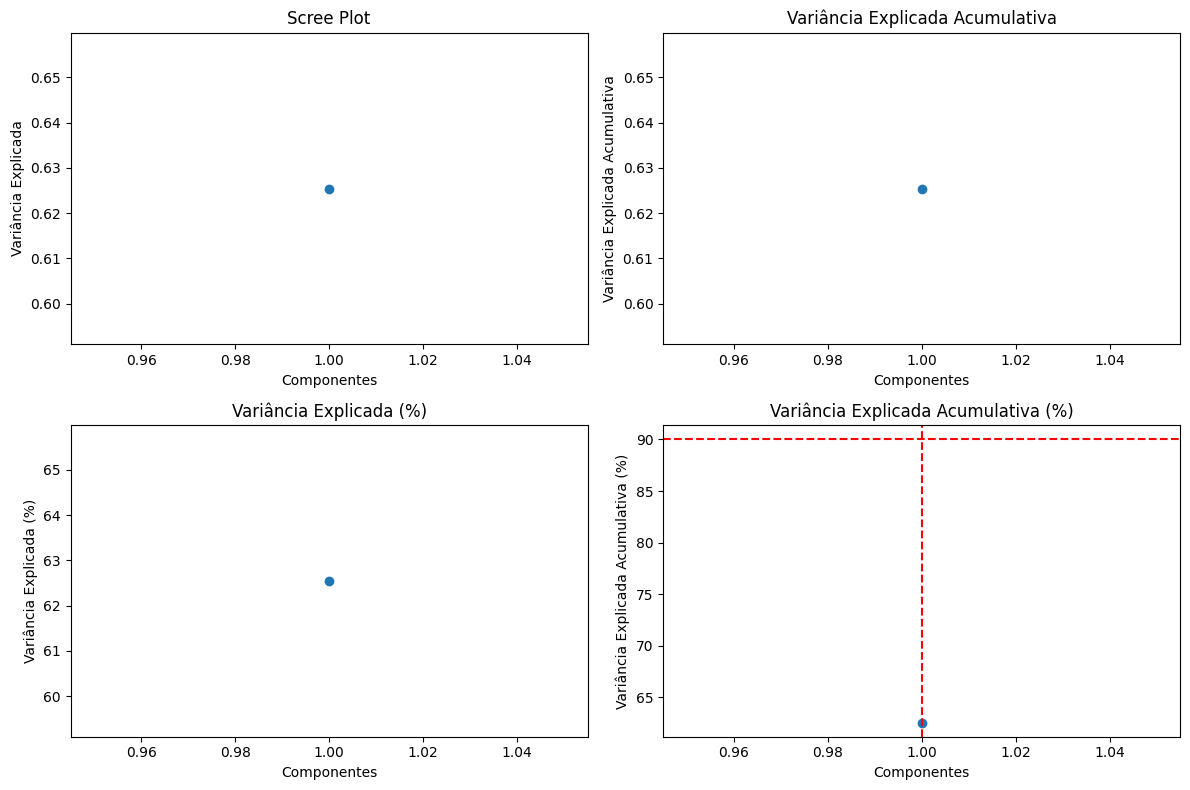

Analise PCA:

Acurácia de Validação:0.584
Acurária de Teste: 0.560
2 explicam 0.675 dos dados.

Tempo: 1.88s

Análise de Variância: 

Base não padronizada.
Componentes que explicam 90% dos dados: 0 componentes


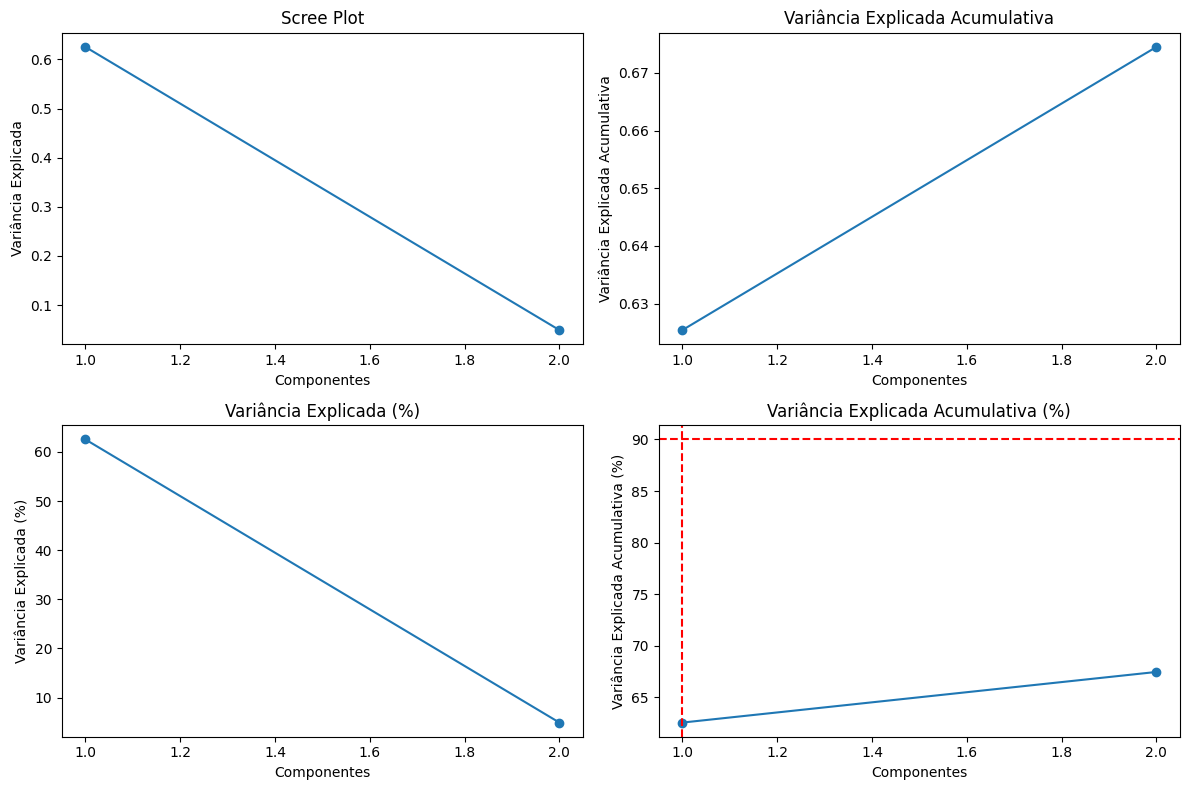

Analise PCA:

Acurácia de Validação:0.829
Acurária de Teste: 0.792
5 explicam 0.751 dos dados.

Tempo: 1.56s

Análise de Variância: 

Base não padronizada.
Componentes que explicam 90% dos dados: 0 componentes


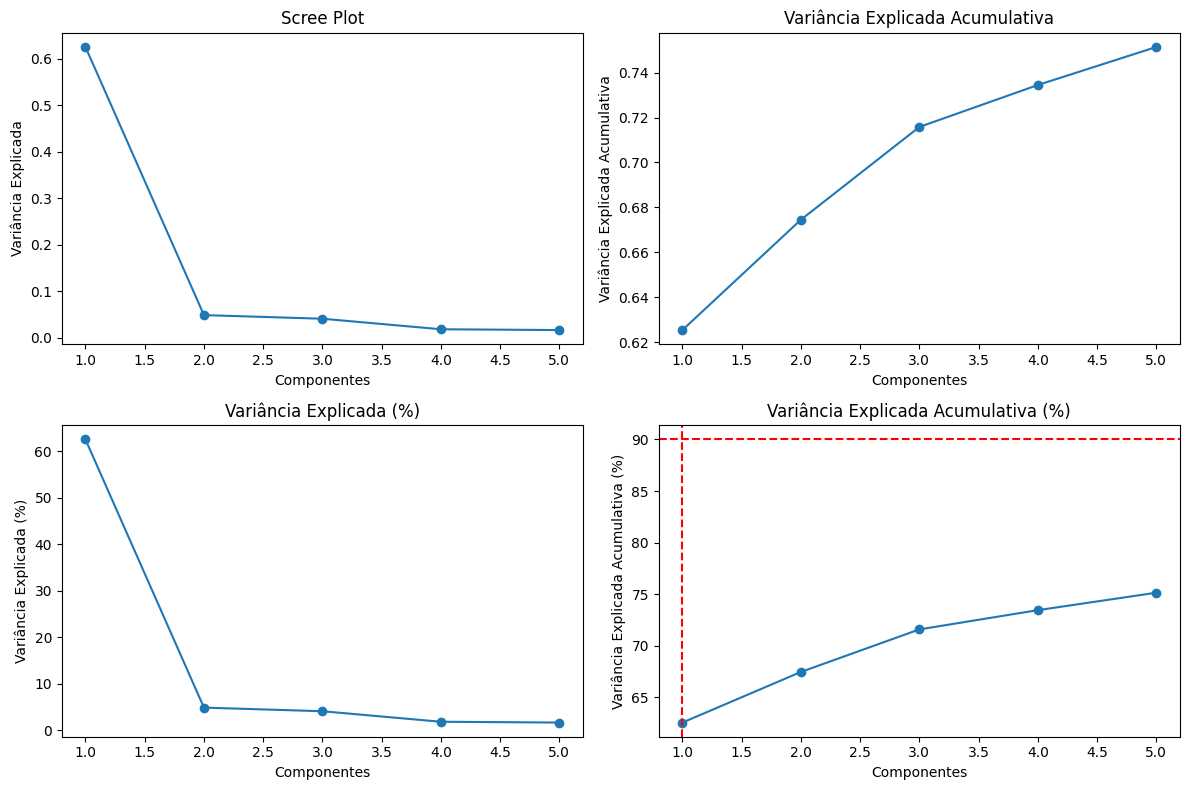

Analise PCA:

Acurácia de Validação:0.865
Acurária de Teste: 0.807
10 explicam 0.805 dos dados.

Tempo: 2.48s

Análise de Variância: 

Base não padronizada.
Componentes que explicam 90% dos dados: 0 componentes


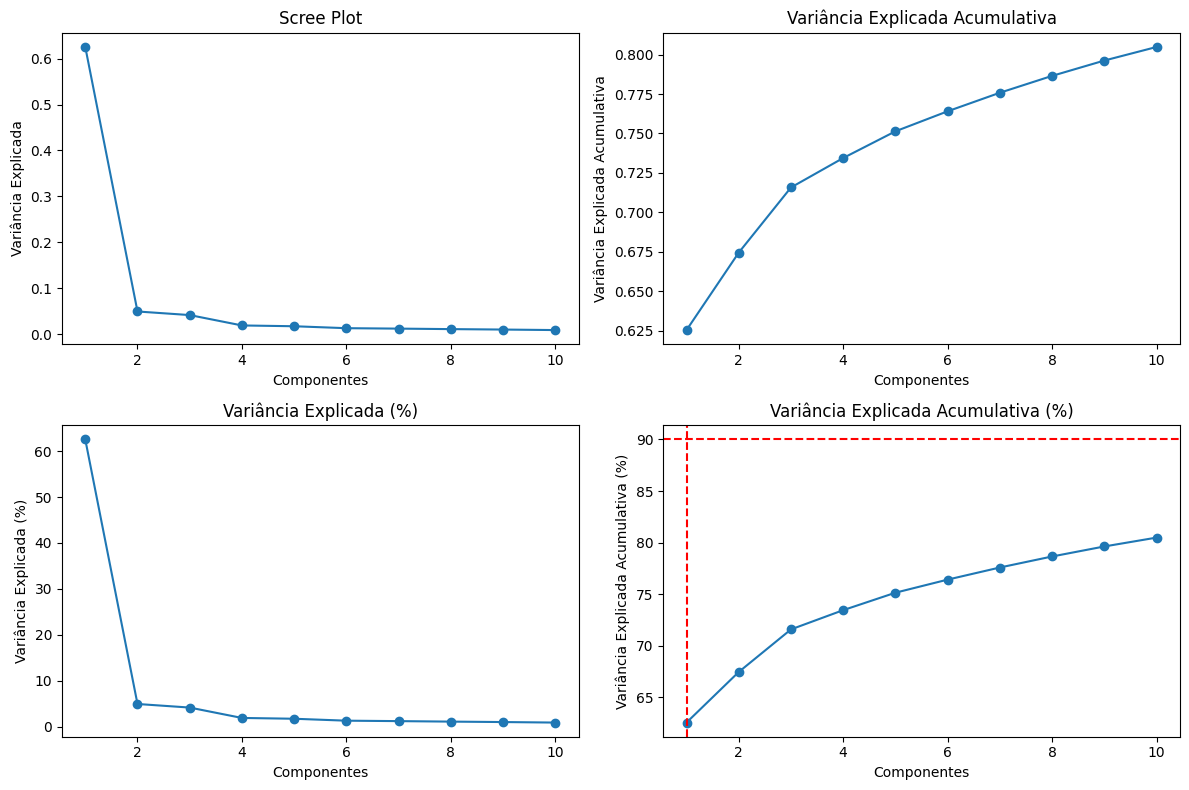

Analise PCA:

Acurácia de Validação:0.862
Acurária de Teste: 0.805
50 explicam 0.931 dos dados.

Tempo: 4.29s

Análise de Variância: 

Base não padronizada.
Componentes que explicam 90% dos dados: 33 componentes


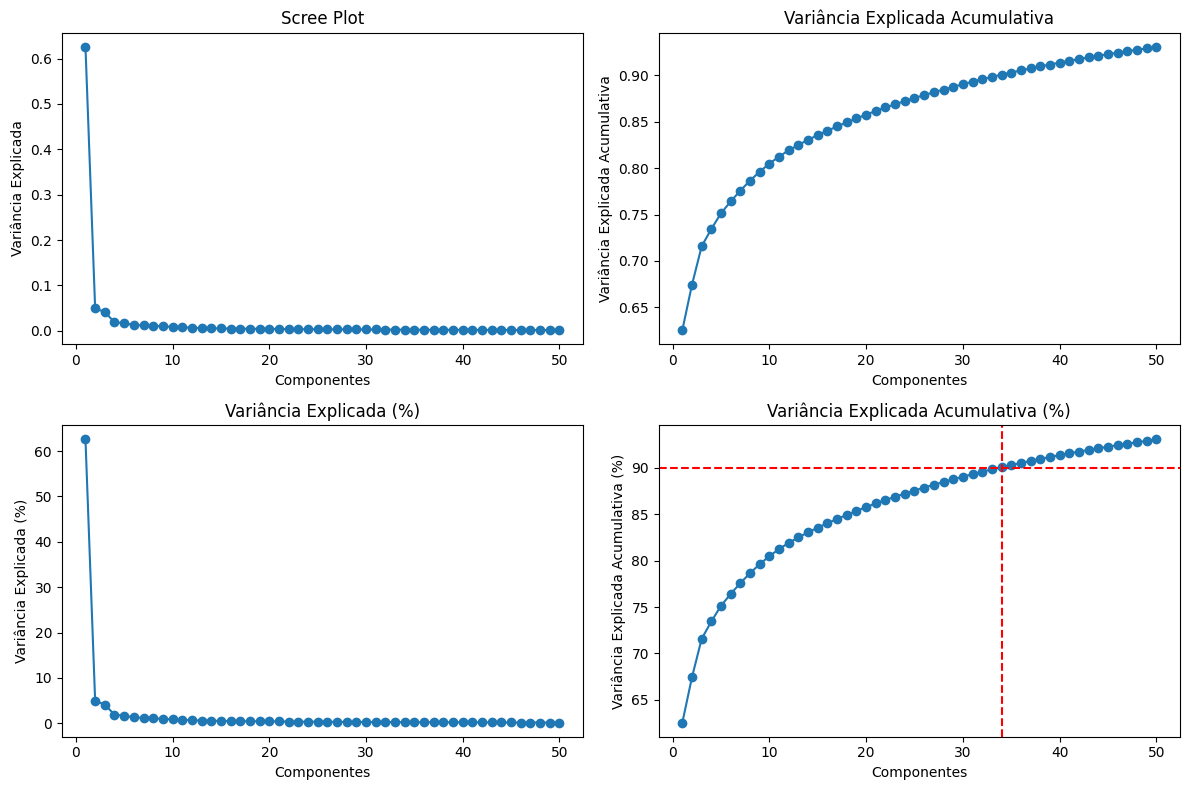

Analise PCA:

Acurácia de Validação:0.872
Acurária de Teste: 0.802
None explicam 1.000 dos dados.

Tempo: 13.80s

Análise de Variância: 

Base não padronizada.
Componentes que explicam 90% dos dados: 33 componentes


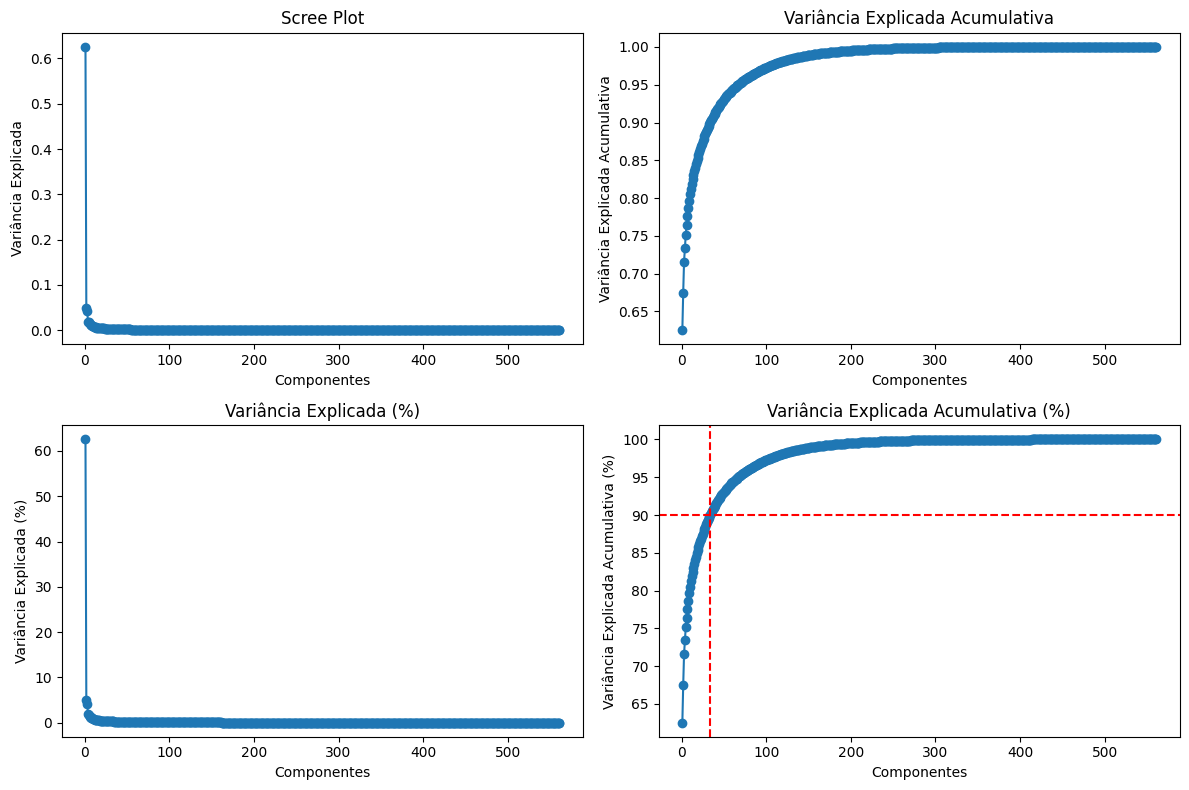

[None, None, None, None, None, None]

In [83]:
# arvore sem padronizar
([main(n_components=n, pct_explained=90, usa_padroniza=False) 
  for n in [1, 2, 5, 10, 50, None]])

### Arvore padronizada

Analise PCA:

Acurácia de Validação:0.491
Acurária de Teste: 0.444
1 explicam 0.625 dos dados.

Tempo: 1.89s

Análise de Variância: 

Base padronizada
Componentes que explicam 90% dos dados: 0 componentes


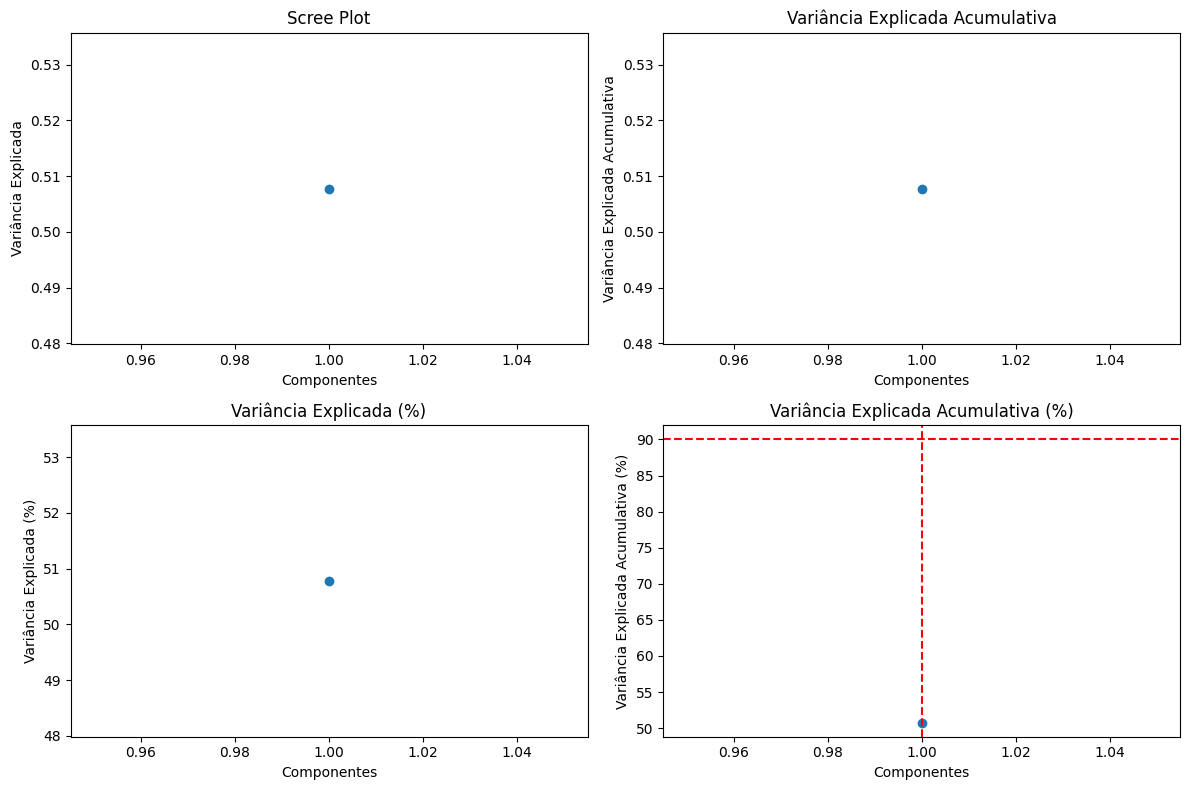

Analise PCA:

Acurácia de Validação:0.584
Acurária de Teste: 0.560
2 explicam 0.675 dos dados.

Tempo: 1.49s

Análise de Variância: 

Base padronizada
Componentes que explicam 90% dos dados: 0 componentes


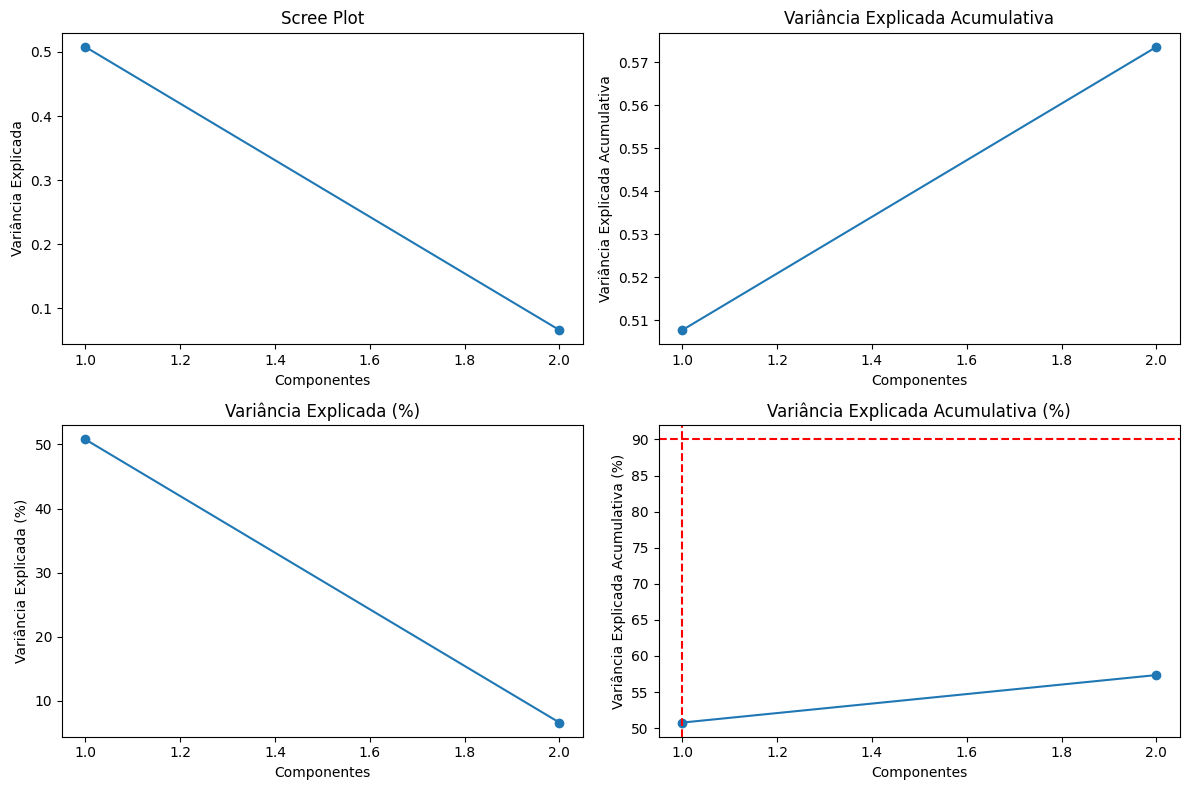

Analise PCA:

Acurácia de Validação:0.829
Acurária de Teste: 0.792
5 explicam 0.751 dos dados.

Tempo: 2.21s

Análise de Variância: 

Base padronizada
Componentes que explicam 90% dos dados: 0 componentes


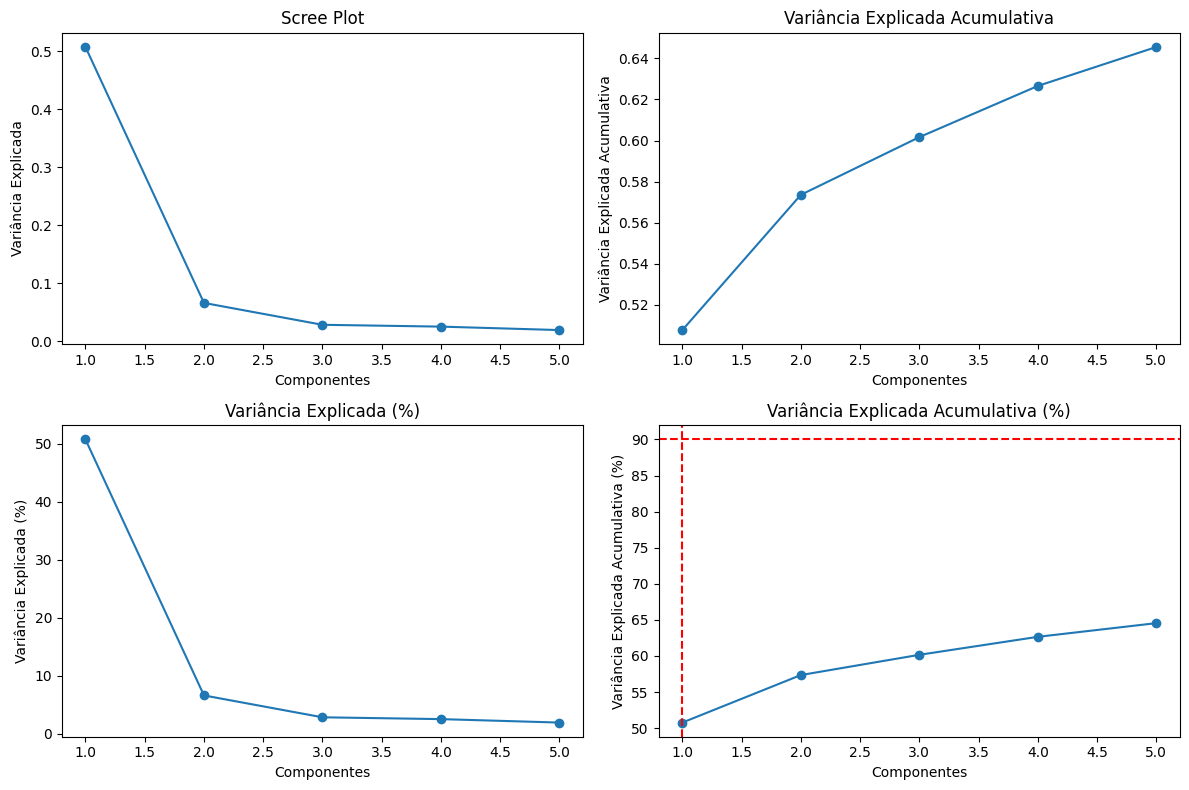

Analise PCA:

Acurácia de Validação:0.865
Acurária de Teste: 0.807
10 explicam 0.805 dos dados.

Tempo: 1.93s

Análise de Variância: 

Base padronizada
Componentes que explicam 90% dos dados: 0 componentes


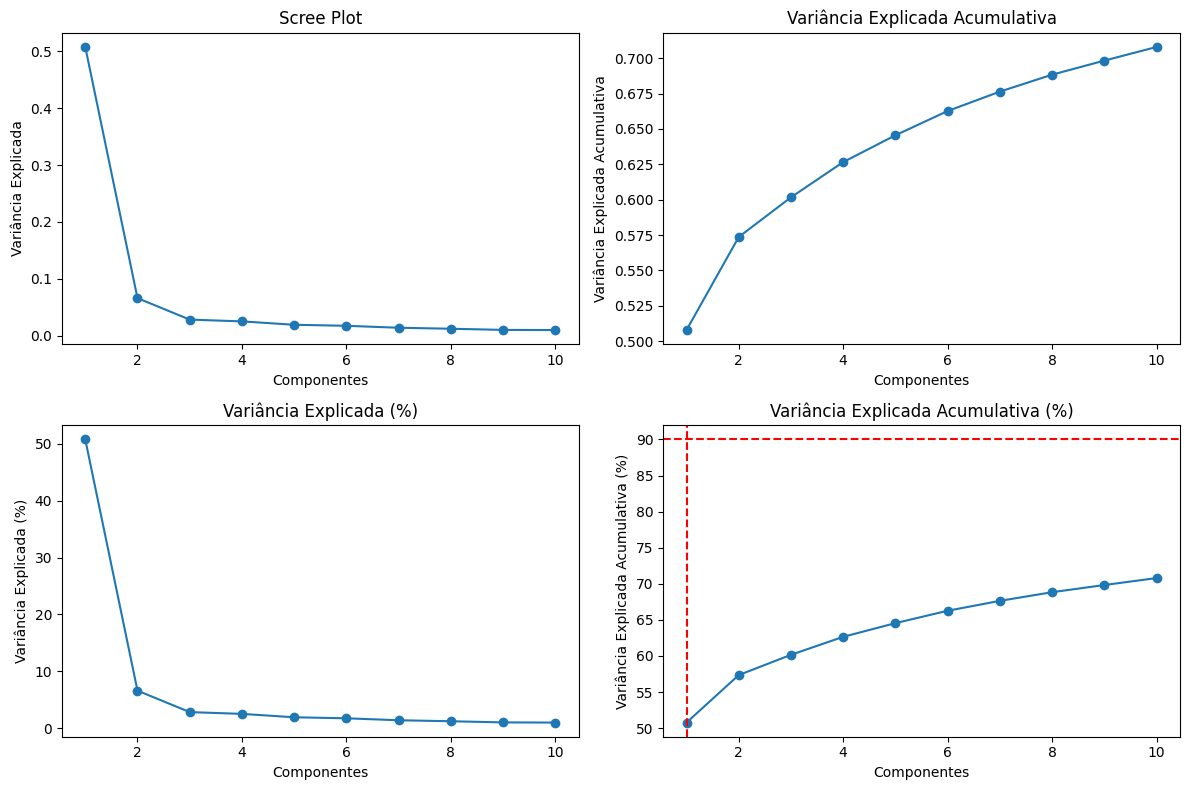

Analise PCA:

Acurácia de Validação:0.862
Acurária de Teste: 0.805
50 explicam 0.931 dos dados.

Tempo: 4.44s

Análise de Variância: 

Base padronizada
Componentes que explicam 90% dos dados: 0 componentes


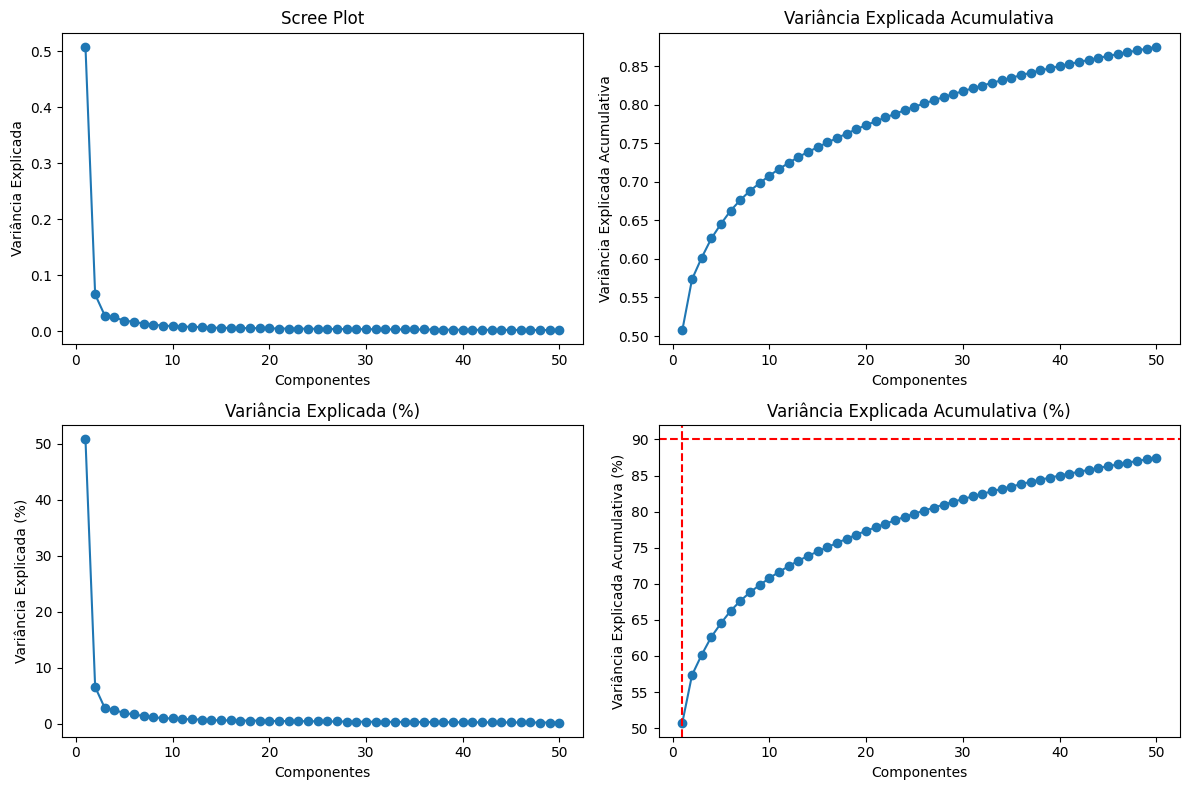

Analise PCA:

Acurácia de Validação:0.872
Acurária de Teste: 0.802
None explicam 1.000 dos dados.

Tempo: 14.23s

Análise de Variância: 

Base padronizada
Componentes que explicam 90% dos dados: 62 componentes


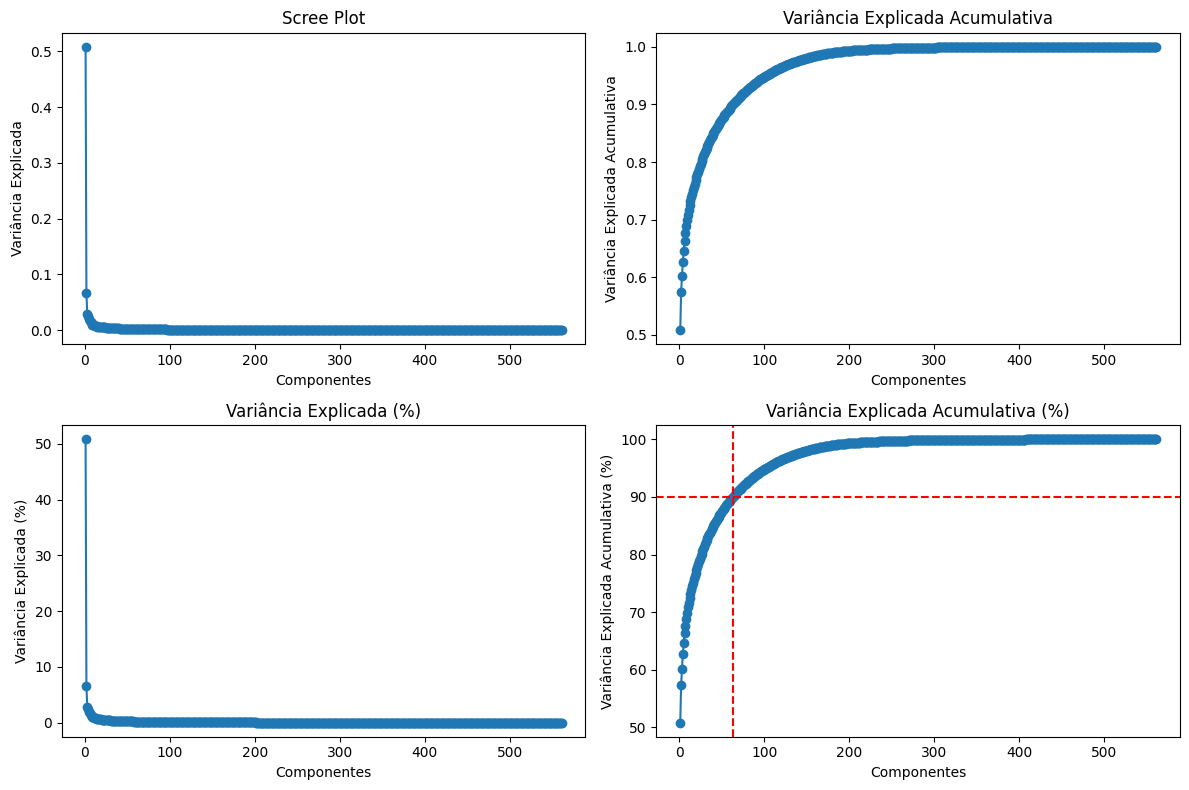

[None, None, None, None, None, None]

In [84]:
# arvore com padronização
([main(n_components=n, pct_explained=90, usa_padroniza=True) 
  for n in [1, 2, 5, 10, 50, None]])

Considerando a padronização, a acurácia não foi alterada, para um mesmo número de componentes. Mas o número minimo de componentes para atingir 90% de variância aumento com a padronização.